# Regression using TA-Regression Library

TA-Regression is Tiger's Regression API that unifies standard libraries like ``Scikit-learn``, ``glmnet`` , ``statsmodels``, ``bambi\PyMC`` and ``tensorflow-probability``. Additionally, it introduces constraint counterparts for these libraries where they may not natively support constraint handling. This enables users to apply constraints to their regression models, ensuring that the optimization process adheres to specified constraints, thus enhancing model robustness and interpretability.

**Need for TA-Regression**
- Most of the business rules are applied in modelling through directionality (+ve or -ve ) and upper-lower bounds of coefficients.
- Although for some cases directionality or bounds are naturally followed, when training large number of models, enforcing the rules is not straight forward. Most cases it is dealt with post correction of coefficients.
- Scikit-Learn & Statsmodels do not allow us to constraint the coefficients. Even if some other libraries do with limited functionality, we have to use different libraries/APIs.

Following are the gaps in the ecosystem TA-Regression fills.
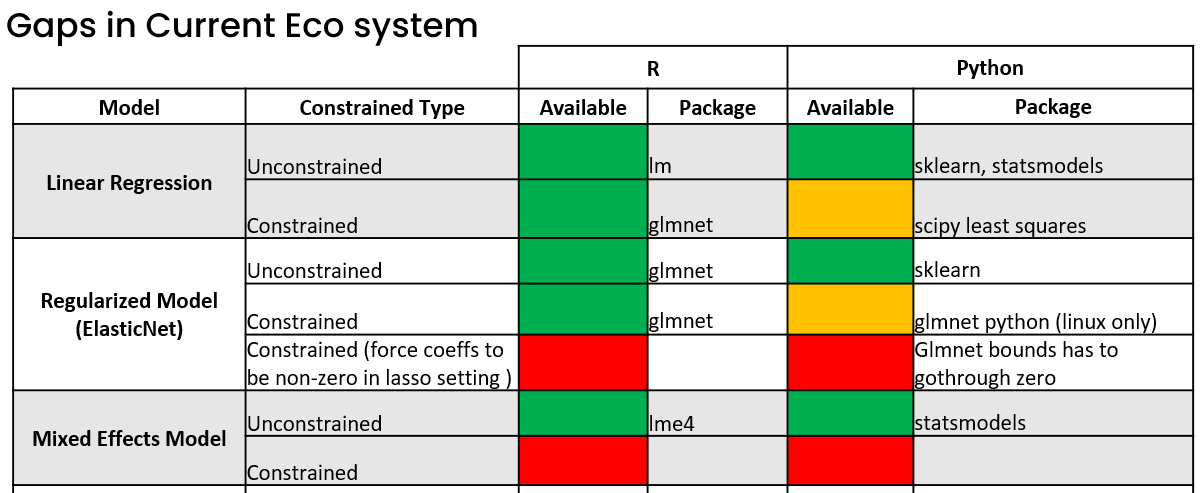

In the previous notebook (i.e ``03_model_experimentating``), we have seen how to do feature engineering including outlier handling and encoding, feature transformation and modelling using sklearn and xgboost libraries.

In this notebook we show the process of model experimenting with [ta_regression](https://tigeranalytics-code-templates.readthedocs-hosted.com/projects/taregression/en/latest/overview.html#taregression) for the same problem statement.

# 1 Setup

**Note**: In order to execute this notebook, you need to install the``tareg`` addons. Follow these steps:

**Step 1**: Activate the code-template environment

**Step 2**:  Execute the command ``inv dev.setup-addon --tareg`` to add the ta_regression addons.

**Step 3 (Optional)**: Run `conda install -c conda-forge -n <env_name> glmnet` to install glmnet package. This step is required only when you intend to use the glmnet backend, and please note that `glmnet` is **only supported on linux**.

In [1]:
%load_ext autoreload
%autoreload 2

### Imports

In [2]:
import warnings
from numba import NumbaDeprecationWarning

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=NumbaDeprecationWarning)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f8cef487f70>>
Traceback (most recent call last):
  File "/home/farhana/conda/envs/new_env-dev/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 788, in _clean_thread_parent_frames
KeyboardInterrupt: 
Exception ignored in sys.unraisablehook: <built-in function unraisablehook>
Traceback (most recent call last):
  File "/home/farhana/conda/envs/new_env-dev/lib/python3.9/site-packages/ipykernel/iostream.py", line 609, in flush
  File "/home/farhana/conda/envs/new_env-dev/lib/python3.9/threading.py", line 581, in wait
  File "/home/farhana/conda/envs/new_env-dev/lib/python3.9/threading.py", line 316, in wait
KeyboardInterrupt
KeyboardInterrupt



In [ ]:
import os
import os.path as op
import shutil

# standard third party imports
import numpy as np
print(np.__version__)
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

# impute missing values
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from IPython.display import HTML

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from ta_lib.core.api import (
    custom_train_test_split,
)  # helper function to customize splitting
from scripts import *

In [ ]:
# standard code-template imports
from ta_lib.core.api import (
    create_context,
    get_dataframe,
    get_feature_names_from_column_transformer,
    display_as_tabs,
    initialize_environment,
    load_dataset,
    load_pipeline,
    save_dataset,
    DEFAULT_ARTIFACTS_PATH,
    silence_common_warnings,
)
from ta_lib.data_processing.api import Outlier
import ta_lib.eda.api as eda
from ta_lib.regression.api import RegressionComparison, RegressionReport

# ta_regression imports
from taregression.elastic_net_api import ElasticNet
from taregression.linear_mixed_effects_api import LinearMixedEffects
from taregression.bayes_api import BayesianRegression

# from taregression.linear_api import LinearRegression

initialize_environment(debug=False, hide_warnings=True)

In [ ]:
artifacts_folder = DEFAULT_ARTIFACTS_PATH

config_path = op.join("conf", "config.yml")
context = create_context(config_path)

# 2 Feature Engineering

The emphasis here lies on the ``Pipeline`` rather than the model itself. While the model choice guides the pipeline required for training, our objective is to configure it in a manner conducive to saving/loading and easy adaptation for different model selections.

## 2.1 Read the Cleaned Sales Data

In [ ]:
sales_data = load_dataset(context, "cleaned/sales")

- We split the data into train and test.
- In this example, we are binning the selling_price into 10 quantiles and then use a Stratified Shuffle to split the data.
- See sklearn documentation on the various available splitters
- https://scikit-learn.org/stable/modules/classes.html#splitter-classes

- After splitting, we filter out rows where the ``quantity`` and ``unit_price`` are negetive as they do not make sense for modelling.

In [ ]:
splitter = StratifiedShuffleSplit(
    n_splits=1, test_size=0.2, random_state=context.random_seed
)
# helper function to customize splitting
sales_df_train, sales_df_test = custom_train_test_split(
    sales_data, splitter, by=binned_selling_price
)

sales_df_train = sales_df_train[sales_df_train["quantity"] > 0]
sales_df_train = sales_df_train[sales_df_train["unit_price"] > 0]

sales_df_test = sales_df_test[sales_df_test["quantity"] > 0]
sales_df_test = sales_df_test[sales_df_test["unit_price"] > 0]

len(sales_df_train), len(sales_df_test)

## 2.2 Feature Engineering Pipelines


**Dev NOTES**

For Feature Engineering, sklearn.pipeline.Pipeline are leveraged because of the following advantages
<details>
    
1. It helps in automating workflows and are easier to read and comprehend.
2. Right Sequence can be ensured and (for example always encodes before imputing)
3. Reproducibility is very convenient with pipelines
4. Pipelines help you prevent data leakage in your test data
5. Code is near implementation ready

#### General Steps in the Feature Transformation are as follows
 - Outlier Treatment
 - Encoding of Categorical Columns
 - Missing Values Imputation

In [ ]:
# collecting different types of features for transformations (unit_price is the target)
cat_columns = (
    sales_data.loc[:, sales_data.columns != "unit_price"]
    .select_dtypes("object")
    .columns
)
num_columns = (
    sales_data.loc[:, sales_data.columns != "unit_price"]
    .select_dtypes("number")
    .columns
)

#### 2.2.1 Outlier Handling
- A Custom Transformer is used to handle outliers. It is not included as part of the pipeline as outliers handling are optional for test data
- An option to either drop or cap the outliers can be passed during the transform call
- If we want to treat outliers for some columns them we can pass cols argument to the Transformer

In [ ]:
outlier_transformer = Outlier(method="mean")
print(sales_df_train.shape)

sales_df_train = outlier_transformer.fit_transform(sales_df_train)
print(sales_df_train.shape)

#### 2.2.2 Encoding

Some notes on how to create column specific pipelines and integrating them overall is presented below-

- Commonly target encoding is done for categorical variables with too many levels.
- For fewer categorical levels one hot encoding/label encoding is preferred.
- If there is one dominant level, we can use binary encoding.
- As shown in the ``03_model_experimentation`` notebook, we proceed with Target Encoding as the categorical variables are present with too many levels
- **NOTE**: Unlike the ``03_model_experimentation`` notebook, ``brand`` column is not encoded as it will be used in TA Regression's ``LinearMixedEffects`` model as a grouping factor. This will be explained once you reach Section 3.2


In [ ]:
tgt_enc_simple_impt = Pipeline(
    [
        ("target_encoding", TargetEncoder(return_df=False)),
        ("simple_impute", SimpleImputer(strategy="most_frequent")),
    ]
)


# NOTE: the list of transformations here are not sequential but weighted
# (if multiple transforms are specified for a particular column)
# for sequential transforms use a pipeline as shown above.
features_transformer = ColumnTransformer(
    [
        ## categorical columns
        (
            "tgt_enc",
            TargetEncoder(return_df=False),
            list(
                set(cat_columns)
                - set(["technology", "functional_status", "platforms", "brand"])
            ),
        ),
        # NOTE: if the same column gets repeated, then they are weighed in the final output
        # If we want a sequence of operations, then we use a pipeline but that doesen't YET support
        # get_feature_names.
        (
            "tgt_enc_sim_impt",
            tgt_enc_simple_impt,
            ["technology", "functional_status", "platforms"],
        ),
        ## numeric columns
        ("med_enc", SimpleImputer(strategy="median"), num_columns),
    ]
)

## 2.3 Feature analysis

Using the pipeline above, we analyze the features and decide on additional features to add/remove from the pipeline.

Here we are primarily focused on feature selection/elimination based on business rules, prior knowledge, data analysis.

**We are not building any models at this point.**


First, we run our Feature Engineering Pipeline on a small fraction of data to test if it works as a best practice. This allows you to validate the pipeline and also identify issues faster.

In [ ]:
sample_X = sales_df_train.loc[:, sales_df_train.columns != "unit_price"].sample(
    frac=0.1, random_state=context.random_seed
)
sample_y = sales_df_train[["unit_price"]].loc[sample_X.index]

sample_train_X = get_dataframe(
    features_transformer.fit_transform(sample_X, sample_y),
    get_feature_names_from_column_transformer(features_transformer),
)

# nothing to do for target
sample_train_y = sample_y

Since the feature transformer worked on the sample data, we are proceeding to apply it on the entire dataset

In [ ]:
# Keeping the unencoded brand for using as grouping factor in Linear Mixed Effects
brand = sales_df_train[["brand"]]
train_X = sales_df_train.loc[:, sales_df_train.columns != "unit_price"]

In [ ]:
train_X = get_dataframe(
    features_transformer.fit_transform(train_X, sales_df_train[["unit_price"]]),
    get_feature_names_from_column_transformer(features_transformer),
)
train_X = pd.concat(
    [train_X.reset_index(drop=True), brand.reset_index(drop=True)], axis=1
)
sales_df_train = pd.concat(
    [
        train_X.reset_index(drop=True),
        sales_df_train[["unit_price"]].reset_index(drop=True),
    ],
    axis=1,
)
sales_df_train.info()

In [ ]:
# converting numerical columns to float type
numeric_columns = list(set(train_X.columns) - set(cat_columns))
sales_df_train[numeric_columns] = sales_df_train[numeric_columns].astype(float)

In [ ]:
# Transformed data
sales_df_train.head()

### 2.3.1 Univariate

- Now that we have our transformed data from our pipelines, we can look at each variable independently. This is useful if your models have assumptions on the distribution and/or bounds on the features/target.

- Since this was already covered in ``03_model_experimentation`` notebook , we will skip it here.

### 2.3.2 Bivariate - mutual interactions

- Here we find columns with high correlations and drop them.
- As observed in ``03_model_experimentation`` notebook, we will be dropping some features due to high correlation.

In [ ]:
# channel and source_channel highly correlated. So discarding source_channel
# manufacturer is always Apple so discarding manufacturer.
# Similarly keeping sku between inventory and sku
# Similarly keeping condition between conditions and ext_grade
# Similarly keeping ext_model_family between platforms, ext_model_family and model_family
# Discarding selling price & selling cost as they are multiples of unit price/cost & quantity.
# Discarding gp as it is the difference of selling price and selling cost
# # order_no, line, invoice_no & customername cannot be IDVs
# discarding color since it has no impact on sales
curated_columns = list(
    set(sales_df_train.columns.to_list())
    - set(
        [
            "source_channel",
            "manufacturer",
            "inventory_id",
            "ext_grade",
            "model_family",
            "line",
            "inventory_id",
            "gp",
            "selling_price",
            "selling_cost",
            "invoice_no",
            "customername",
            "order_no",
            "color",
            "tgt_enc_sim_impt_x1",
            "tgt_enc_sim_impt_x2",
            "tgt_enc_sim_impt_x0",
        ]
    )
)

sales_df_train = sales_df_train[curated_columns]

### 2.3.3 Applying the fitted Feature Engineering Pipeline on the test data

- Now that we have finished Feature Engineering + Feature Analysis on the train data, we will transform the test data using the same pipelines

In [ ]:
brand = sales_df_test[
    ["brand"]
]  # Keeping the unencoded brand for using as grouping factor in Linear Mixed Effects
test_X = sales_df_test.loc[:, sales_df_test.columns != "unit_price"]
test_X = get_dataframe(
    features_transformer.fit_transform(test_X, sales_df_test[["unit_price"]]),
    get_feature_names_from_column_transformer(features_transformer),
)
test_X = pd.concat(
    [test_X.reset_index(drop=True), brand.reset_index(drop=True)], axis=1
)
sales_df_test = pd.concat(
    [
        test_X.reset_index(drop=True),
        sales_df_test[["unit_price"]].reset_index(drop=True),
    ],
    axis=1,
)
sales_df_test = sales_df_test[curated_columns]

In [ ]:
# dropping none values
sales_df_train = sales_df_train.dropna().reset_index(drop=True)
sales_df_test = sales_df_test.dropna().reset_index(drop=True)
print(sales_df_train.shape)
print(sales_df_test.shape)

We have now completed the preparation of the data and are ready to move to Modelling with TA Regression

# 3 Modelling

## Background Recap

Customer is a distributor of electronic devices. They partner with manufacturers, carriers and refurbishers and sell across to  retailers. The selling price is the outcome of negotiation between sales representatives and retailers. Customer wants to understand the selling price variation and determine  optimal pricing with Machine Learning.

The objective of this notebook is to get the feature coefficients by modelling unit prices as a function of unit cost and other variables. First we will  create models that can predict prices only for one brand at a time (using TA Regression's ``ElasticNet`` model) and compare their performances, and then we'll create models that can predict prices for all brands at the same time (using TA Regression's ``LinearMixedEffects`` and ``BayesianRegression`` Models).

## 3.1 TA Regression's ElasticNet

This Model is wrapper of the Scikit-learn, glmnet-python and ta regression elasticnet algorithms.

### 3.1.1 Simple Additive ElasticNet model

- We can build a model by implementing the Regularised regression using `ElasticNet` API

- Let's model the elastic net using the `scikit-learn` backend, where we have to provide the `lmbd` parameter (shrinkage) explicitly.

- Given the nested nature of data, models needs to be run per group. Here, ``brand`` is identified as a grouping factor since prices, sales tend to vary based on brand (ex. APPLE, SAMSUNG, HTC etc).

- Hence, ElasticNet will be run at the brand level. We take an example of a single brand APPLE.

To know about available backends in ElasticNet, please refer [here](https://tigeranalytics-code-templates.readthedocs-hosted.com/projects/taregression/en/latest/overview.html#elasticnet)

In [ ]:
brand = "APPLE"
df_merged_one_brand = sales_df_train[sales_df_train["brand"] == brand]
df_merged_test_one_brand = sales_df_test[sales_df_test["brand"] == brand]
len(df_merged_one_brand), len(df_merged_test_one_brand)

Specifying the model equation is very similar to [`R lang` `lme4`](https://bbolker.github.io/mixedmodels-misc/glmmFAQ.html#model-specification) style Wilkinson's formulas.

In [ ]:
model_equation = (
    "unit_price ~  unit_cost + carrier + "
    + "condition + days_since_last_purchase + "
    + "first_time_customer + lock_status + "
    + "memory_size + quantity + ext_model_family + "
    + "sales_person + business_unit + channel +order_type"
)

In [ ]:
en_model = ElasticNet(model_equation, backend="sklearn")
en_model.fit(df_merged_one_brand, alpha=0.5, lmbd=0.3, max_iter=10000)
en_model.get_coefficients()

As you can see in the above example, too many features have been suppressed, indicating that the chosen `lmbd` value might be big. Lets try another experiment with a smaller `lmbd` value 

In [ ]:
en_model.fit(df_merged_one_brand, alpha=0.5, lmbd=0.003, max_iter=10000)
en_model.get_coefficients()

Getting Model Report

In [ ]:
y_hat_en_model_train = en_model.predict(df_merged_one_brand)
y_hat_en_model_test = en_model.predict(df_merged_test_one_brand)
x_train = df_merged_one_brand.loc[:, df_merged_one_brand.columns != "unit_price"]
y_train = df_merged_one_brand[["unit_price"]]
x_test = df_merged_test_one_brand.loc[:, df_merged_one_brand.columns != "unit_price"]
y_test = df_merged_test_one_brand[["unit_price"]]

en_report = RegressionReport(
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    yhat_train=y_hat_en_model_train,
    yhat_test=y_hat_en_model_test,
)
en_report.get_report(include_shap=False, file_path="reports/en_model_report")

### 3.1.2 Additive ElasticNet with constraints

- In certain scenarios, you might want to influence the values of coefficients as per business logic. To do this, we can set constrains to the coefficients. In below scenario, we have set constrains to ``business_unit`` and ``unit_cost`` to be explicitly positive in a given range.

- Using `custom` package, we are able to not only explicitly specify `lmbd` parameter to `ElasticNet`, but also constrain coefficients as desired

**CAUTION**
- Apply constraints to coefficients cautiously, as they may affect model performance and hinder the accurate capture of independent variable impacts.
- Avoid setting excessively tight constraints. Use this primarily for establishing directionality rather than strict limitations.
- Compare constrained models with unconstrained models to evaluate the impact of constraints on model performance effectively.
- With great power comes great responsibility, so use this wisely 😀

In [ ]:
en_model_constrained = ElasticNet(model_equation, backend="custom")
en_model_constrained.fit(
    df_merged_one_brand,
    alpha=0.5,
    lmbd=0.003,
    box_constraints={"unit_cost": (0.4, 4), "business_unit": (0.001, 2)},
)
en_model_constrained.get_coefficients()

Getting Model Report

In [ ]:
y_hat_en_model_con_train = en_model_constrained.predict(df_merged_one_brand)
y_hat_en_model_con_test = en_model_constrained.predict(df_merged_test_one_brand)
x_train = df_merged_one_brand.loc[:, df_merged_one_brand.columns != "unit_price"]
y_train = df_merged_one_brand[["unit_price"]]
x_test = df_merged_test_one_brand.loc[:, df_merged_one_brand.columns != "unit_price"]
y_test = df_merged_test_one_brand[["unit_price"]]

en_con_report = RegressionReport(
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    yhat_train=y_hat_en_model_con_train,
    yhat_test=y_hat_en_model_con_test,
)

en_con_report.get_report(include_shap=False, file_path="reports/en_con_model_report")

## 3.2 TA Regression's LinearMixedEffects

This Model is wrapper of the statsmodel linear mixed effects and custom linear mixed effects algorithms.

### 3.2.1 Linear Mixed Effects model

- In previous examples, we constructed additive linear models for individual brands. However, extending this approach to all model families within the dataset could become cumbersome. 

- Utilizing TA Regression's ``LinearMixedEffects`` (LME) models proves beneficial in nested or grouped datasets where certain features are dependent on a grouping factor.

- In this context,``brand`` is identified as a grouping factor, as prices and sales tend to vary based on different brands (e.g., APPLE, SAMSUNG, HTC, etc).

- We can designate features that vary between brands as **random effects** and retain features that demonstrate consistent behavior across brands as **fixed effects**.

- Since change in ``unit_cost`` will not linearly affect ``unit_prices``, a `Log-Log` transformation to these 2 variables is done in the ``model_equation``, as show below.

- Here's how we can implement LME using a ``statsmodels`` backend.

To know more about supported backends in LinearMixedEffects (LME), please refer [here](https://tigeranalytics-code-templates.readthedocs-hosted.com/projects/taregression/en/latest/overview.html#linearmixedeffects)

Specifying the model_equation is very similar to [`R lang` `lme4`](https://bbolker.github.io/mixedmodels-misc/glmmFAQ.html#model-specification) style Wilkinson's formulas.

In [ ]:
lme_model_equation = (
    "np.log1p(unit_price) ~ "
    + "channel + order_type + sales_person + business_unit + carrier + lock_status + condition"
    + " + first_time_customer + days_since_last_purchase + memory_size + "
    + "(np.log1p(unit_cost)|brand) + (quantity|brand) + 1|brand"
)

Notice the `cost` feature specified in the formula as `(np.log1p(unit_cost)|brand)`. In this example, we are specifying `np.log1p(unit_cost)` as random effect of `brand`, i.e, each `brand` will have a different coefficient for `np.log1p(unit_cost)`

The test and train data will be filtered with common brands between the both.

In [ ]:
common_brands = list(
    set(sales_df_train.brand.unique()).intersection(sales_df_test.brand.unique())
)
sales_df_test = sales_df_test[sales_df_test["brand"].isin(common_brands)]
sales_df_train = sales_df_train[sales_df_train["brand"].isin(common_brands)]

In [ ]:
lme_model = LinearMixedEffects(
    lme_model_equation, backend="statsmodels"
)  # default backend is statsmodels
lme_model.fit(sales_df_train, verbose=True)

Identifying fixed effects coefficients

In [ ]:
coeff = lme_model.get_coefficients()
fixed_coeff = pd.DataFrame(
    coeff["common"].items(), columns=["Independent_var", "coeff"]
)
fixed_coeff

Identifying random effects coefficients

In [ ]:
coeff["group"]
group = pd.DataFrame()
for i in coeff["group"].keys():
    x = pd.DataFrame(coeff["group"][i].items(), columns=["group", "coeff"])
    x["Independent_var"] = i
    group = pd.concat([group, x])
random_coeff = group[["Independent_var", "group", "coeff"]]
random_coeff

Checking ``unit_cost`` coeff values

In [ ]:
random_coeff[random_coeff["Independent_var"] == "np.log1p(unit_cost)|brand"]

Getting Model Report

In [ ]:
y_hat_lme_model_train = np.expm1(lme_model.predict(sales_df_train))
y_hat_lme_model_test = np.expm1(lme_model.predict(sales_df_test))
x_train = sales_df_train.loc[:, sales_df_train.columns != "unit_price"]
y_train = sales_df_train[["unit_price"]]
x_test = sales_df_test.loc[:, sales_df_test.columns != "unit_price"]
y_test = sales_df_test[["unit_price"]]

In [ ]:
lme_report = RegressionReport(
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    yhat_train=y_hat_lme_model_train,
    yhat_test=y_hat_lme_model_test,
)
lme_report.get_report(include_shap=False, file_path="reports/lme_model_report")

### 3.2.2 Linear Mixed Effects with constraint

- The coefficient of `np.log1p(unit_cost)|brand` should be positive. If we do not put constraints on the LME model, there are chances that the unit_cost coefficient may get a negative coefficient, which is not desired. 

- Hence, We need to constrain it.

- Since we cannot achieve it using `statsmodels`, we need to utilize LinearMixedEffect's `custom` backend

**CAUTION**
- Apply constraints to coefficients cautiously, as they may affect model performance and hinder the accurate capture of independent variable impacts.
- Avoid setting excessively tight constraints. Use this primarily for establishing directionality rather than strict limitations.
- Compare constrained models with unconstrained models to evaluate the impact of constraints on model performance effectively.
- With great power comes great responsibility, so use this wisely 😀

In [ ]:
lme_model_constrained = LinearMixedEffects(lme_model_equation, backend="custom")
lme_model_constrained.fit(
    sales_df_train,
    verbose=True,
    box_constraints={
        "np.log1p(unit_cost)|brand": (0.4, 4),
    },
)

Identifying fixed effects coefficients

In [ ]:
coeff = lme_model_constrained.get_coefficients()
fixed_coeff_coeff = pd.DataFrame(
    coeff["common"].items(), columns=["Independent_var", "coeff"]
)
fixed_coeff

Identifying random effects coefficients

In [ ]:
coeff["group"]
group = pd.DataFrame()
for i in coeff["group"].keys():
    x = pd.DataFrame(coeff["group"][i].items(), columns=["group", "coeff"])
    x["Independent_var"] = i
    group = pd.concat([group, x])
random_coeff = group[["Independent_var", "group", "coeff"]]
random_coeff

Getting Model Report

In [ ]:
y_hat_lme_model_con_test = np.expm1(lme_model_constrained.predict(sales_df_test))
y_hat_lme_model_con_train = np.expm1(lme_model_constrained.predict(sales_df_train))
x_train = sales_df_train.loc[:, sales_df_train.columns != "unit_price"]
y_train = sales_df_train[["unit_price"]]
x_test = sales_df_test.loc[:, sales_df_test.columns != "unit_price"]
y_test = sales_df_test[["unit_price"]]

lme_con_report = RegressionReport(
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    yhat_train=y_hat_lme_model_con_train,
    yhat_test=y_hat_lme_model_con_test,
)
lme_con_report.get_report(include_shap=False, file_path="reports/lme_model_con_report")

## 3.3 TA Regression's BayesianRegression

This Model is wrapper of the Tensorflow Probability and Bambi bayesian regression libraries.

Need a 101 on Bayesian modelling?. Refer [here](https://tigeranalytics-code-templates.readthedocs-hosted.com/en/latest/pov/bayesian_101.html)

### 3.3.1 Hierarchical Linear Regression

- We can also model the data using TA Regression's ``BayesianRegression`` model. 

- In order to build a single model for all brands and jointly learn across brands we can build a mixed effects model where cost will be random by brands and other features can be fixed effect. 

- Here is how we can implement using ``bambi`` backend.

- The following implementation is done without giving any constrains.

To explore the available backend options in ``BayesianRegression``, kindly refer [here](https://tigeranalytics-code-templates.readthedocs-hosted.com/projects/taregression/en/latest/overview.html#bayesianregression)

Specifying the model_equation is very similar to [`R lang` `lme4`](https://bbolker.github.io/mixedmodels-misc/glmmFAQ.html#model-specification) style Wilkinson's formulas.

We will use the same ``model_equation`` we used in LinearMixedEffects model.

**NOTE**: In practice , the draws and tunes are generally set to higher numbers (eg. draws=2000, tune=1000). Depending on the size of these parameters, the time taken to fit the model will be lengthy. Setting higher draws and tune parameters generally lead to better results.

In this case, we have set the draws and tunes to a smaller number for the purpose of going through the implementation

In [ ]:
bayesian_model = BayesianRegression(formula=lme_model_equation, backend="bambi")
bayesian_result = bayesian_model.fit(
    sales_df_train,
    model_params={
        "draws": 10,
        "tune": 10,
        "inference_method": "mcmc",
    },
)

In [ ]:
bayesian_model.get_summary()

Getting Model Report

In [ ]:
y_hat_bayes_model_train = bayesian_model.predict(sales_df_train)
y_hat_bayes_model_test = bayesian_model.predict(sales_df_test)
x_train = sales_df_train.loc[:, sales_df_train.columns != "unit_price"]
y_train = sales_df_train[["unit_price"]]
x_test = sales_df_test.loc[:, sales_df_test.columns != "unit_price"]
y_test = sales_df_test[["unit_price"]]

bayes_report = RegressionReport(
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    yhat_train=y_hat_bayes_model_train,
    yhat_test=y_hat_bayes_model_test,
)
bayes_report.get_report(include_shap=False, file_path="reports/bayes_model_report")

### 3.3.2 Hierarchical Linear Regression with constraint using priors

- If the user already has a prior knowledge of the data and wants to influence the coefficients, TA Regression allows you to set the priors.

- In this context, we can set priors for ``np.log1p(unit_cost)`` using a Truncated Normal distribution.

- We define priors as follows- either ``mu`` or ``sigma`` of the prior itself will be a distribution. This approach to defining priors is known as partial pooling.

**CAUTION**
- Apply constraints to coefficients cautiously, as they may affect model performance and hinder the accurate capture of independent variable impacts.
- Avoid setting excessively tight constraints. Use this primarily for establishing directionality rather than strict limitations.
- Compare constrained models with unconstrained models to evaluate the impact of constraints on model performance effectively.
- With great power comes great responsibility, so use this wisely 😀


In [ ]:
priors_constraint = {
    "np.log1p(unit_cost)|brand": {
        "dist": "TruncatedNormal",
        "mu": {"dist": "Normal", "mu": 1, "sigma": 0.1},
        "sigma": 2,
        "lower": 0,
        "upper": 3,
    }
}

In [ ]:
hierarchical_model_constrained = BayesianRegression(
    formula=lme_model_equation, backend="bambi"
)
hierarchical_result_constrained = hierarchical_model_constrained.fit(
    sales_df_train,
    priors=priors_constraint,
    model_params={
        "draws": 5,
        "tune": 5,
        "inference_method": "nuts_numpyro",
        "postprocessing_chunks": 50,
    },
)

In [ ]:
hierarchical_model_constrained.get_summary()

Getting Model Report

In [ ]:
y_hat_bayes_model_train = hierarchical_model_constrained.predict(sales_df_train)
y_hat_bayes_model_test = hierarchical_model_constrained.predict(sales_df_test)
x_train = sales_df_train.loc[:, sales_df_train.columns != "unit_price"]
y_train = sales_df_train[["unit_price"]]
x_test = sales_df_test.loc[:, sales_df_test.columns != "unit_price"]
y_test = sales_df_test[["unit_price"]]

bayes_con_report = RegressionReport(
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    yhat_train=y_hat_bayes_model_train,
    yhat_test=y_hat_bayes_model_test,
)
bayes_con_report.get_report(
    include_shap=False, file_path="reports/bayes_con_model_report"
)

# 4 Model Comparison

Now, a comparison table of the linear regression, elastic net, linear mixed effect and hierarchical model approach can be created as follows.

## 4.1 Model Comparison for Models Fitted for single brand

- Here we compare the performance of the models for a single brand

In [ ]:
# predicted values for model comparison

y_hat_en_model = en_model.predict(df_merged_test_one_brand)
y_hat_en_model_constrained = en_model_constrained.predict(df_merged_test_one_brand)
y_hat_lme_model = np.expm1(lme_model.predict(df_merged_test_one_brand))
y_hat_lme_model_constrained = np.expm1(
    lme_model_constrained.predict(df_merged_test_one_brand)
)

model_names = [
    "Elastic net model",
    "Elastic net model constrained",
    "LME model",
    "LME model constrained",
]
predictions = [
    y_hat_en_model,
    y_hat_en_model_constrained,
    y_hat_lme_model,
    y_hat_lme_model_constrained,
]

predictions_dict = dict(zip(model_names, predictions))

In [ ]:
model_comparison_report_1 = RegressionComparison(
    y=df_merged_test_one_brand["unit_price"], yhats=predictions_dict
)

report_metrics = model_comparison_report_1.perf_metrics()
metrics = model_comparison_report_1.get_report(file_path="reports/ta_reg_comparison")
HTML(report_metrics.to_html())

## 4.2 Model Comparison for Models Fitted for all brands

- Here we compare the performance of the models across all brands

In [ ]:
all_brand_model_names = [
    "Linear Mix Model",
    "Linear Mix model constrained",
    "Bayesian model",
    "Bayesian model constrained",
]
# predicted values for model comparison

y_hat_lme_model = np.expm1(lme_model.predict(sales_df_test))
y_hat_lme_model_constrained = np.expm1(lme_model_constrained.predict(sales_df_test))
y_hat_hierarchical_model = bayesian_model.predict(sales_df_test)
y_hat_hierarchical_model_constrained = hierarchical_model_constrained.predict(
    sales_df_test
)

all_brand_predictions = [
    y_hat_lme_model,
    y_hat_lme_model_constrained,
    y_hat_hierarchical_model,
    y_hat_hierarchical_model_constrained,
]

all_brand_predictions_dict = dict(zip(all_brand_model_names, all_brand_predictions))

In [ ]:
model_comparison_report_2 = RegressionComparison(
    y=sales_df_test["unit_price"], yhats=all_brand_predictions_dict
)

report_metrics = model_comparison_report_2.perf_metrics()
metrics = model_comparison_report_2.get_report(
    file_path="reports/ta_reg_all_brand_comparison"
)
HTML(report_metrics.to_html())

# 5 Additional Examples

If you need more examples for using TA-Regression , head over to the [Example Section](https://tigeranalytics-code-templates.readthedocs-hosted.com/projects/taregression/en/latest/tutorial.html#) in the documentation